In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os
import json
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query
import plotly.graph_objects as go

# always make it pretty 
plt.style.use('ggplot')

In [2]:
db = global_connect()

## Load data

**Drivers General**

In [71]:
df = careful_query('SELECT * FROM driver')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8195 entries, 0 to 8194
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   driver_id    8195 non-null   object        
 1   min_sent     8195 non-null   datetime64[ns]
 2   max_sent     8195 non-null   datetime64[ns]
 3   pushes       8195 non-null   int64         
 4   itineraries  8195 non-null   int64         
 5   avg_lat      8195 non-null   float64       
 6   avg_lng      8195 non-null   float64       
 7   std_lat      8158 non-null   float64       
 8   std_lng      8158 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 576.3+ KB


In [62]:
df['min_sent'] = pd.to_datetime(df['min_sent'])
df['max_sent'] = pd.to_datetime(df['max_sent'])

In [63]:
df['days'] = df.max_sent - df.min_sent
df['days'] = df['days'].apply(lambda x: x.days)

In [64]:
df.describe()

pushes  itineraries      avg_lat      avg_lng      std_lat  \
count   1778.000000  1778.000000  1778.000000  1778.000000  1778.000000   
mean    6220.073116    59.605174   -23.554467   -46.549259     0.032464   
std    10193.450358    62.463409     0.059370     0.027129     0.017512   
min        5.000000     0.000000   -23.650389   -46.615911     0.000045   
25%      733.250000    17.000000   -23.605875   -46.567859     0.017823   
50%     2237.000000    41.500000   -23.570611   -46.550878     0.027093   
75%     6435.500000    81.000000   -23.500919   -46.529826     0.047560   
max    81994.000000   945.000000   -23.430137   -46.461548     0.091143   

           std_lng         days  
count  1778.000000  1778.000000  
mean      0.025660   273.407199  
std       0.009565   137.104471  
min       0.000186     0.000000  
25%       0.018037   140.000000  
50%       0.025240   270.000000  
75%       0.033090   426.000000  
max       0.053084   434.000000

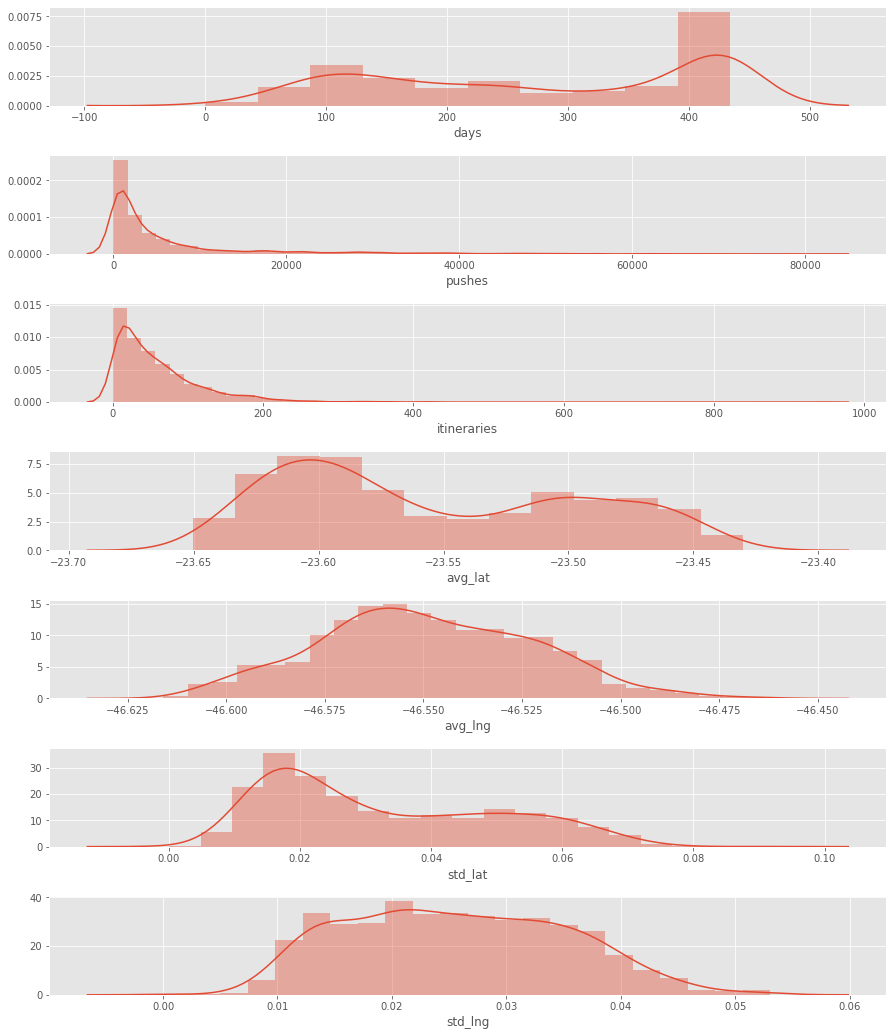

In [65]:
cols = ['days', 'pushes', 'itineraries', 'avg_lat', 'avg_lng', 'std_lat', 'std_lng']
fig, axes = plt.subplots(7, 1, figsize=(15,14))
axes = axes.flatten()
for i, col in enumerate(cols):
    sns.distplot(df[col], ax=axes[i])
    
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.10)

- **days**: most of the drivers in dataset has many days working with Loggi (we are taking into account the first and the last day where the driver's Loggi app sent a push message). It could come in help to count with the number of days where the driver show activity (there is at least 1 push message on a date)
- **pushes**: too skewed, probability of outliers that require to be analyzed. Mean is more than 2.5K but the median is near 0.5K. Appears at least one maximum outlier with  more than 80K pushes. Maybe there are few people that get connected too much time.
- **itineraries**: skewed and similar to pushes (maybe  are the same drivers, so probabily correlation here). The median says that most of drivers are not full dedicated to this job. But at the same time the mean doubles the median alerting us from a skewed distribution. There is at least one driver with neak 1K itineraries. Maybe the employed of the month.

So, until here the above variables could help to create group of drivers.

- **avg_lat and avg_lng** present two long tails to the right. This could mean that some drivers tend to go to the north east.
- **std_lat and std_lng** present two modes. This could mean that we have two types of drivers. Drivers that tend to do many distances and drivers that tend to do the same kind of distance.


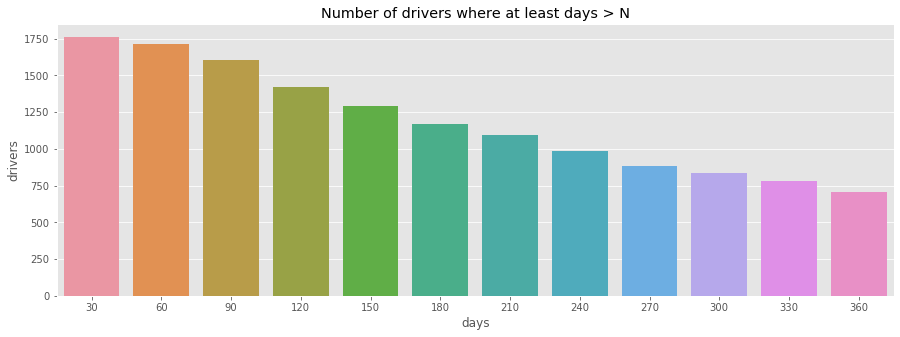

In [66]:
#print('Drivers in available dataset with:')
#for rdays in [(i+1)*30 for i in range(12)]:
#    print('More than {} days: {} ({:0.1f}%)'.format(rdays, sum(df.days > rdays), 100*sum(df.days > rdays)/df.shape[0]))
plt.figure(figsize=(15, 5))
y = [sum(df.days > rdays) for rdays in [(i+1)*30 for i in range(12)]]
x = [rdays for rdays in [(i+1)*30 for i in range(12)]]
sns.barplot(x, y);
plt.title('Number of drivers where at least days > N');
plt.xlabel('days');
plt.ylabel('drivers');

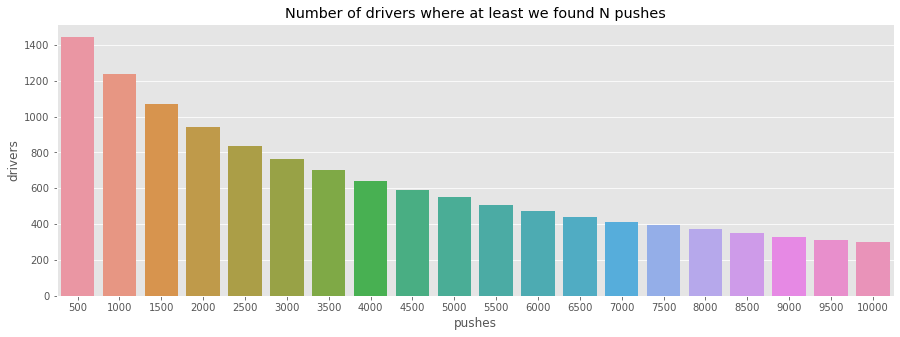

In [67]:
plt.figure(figsize=(15, 5))
y = [sum(df.pushes > p) for p in [(i+1)*500 for i in range(20)]]
x = [p for p in [(i+1)*500 for i in range(20)]]
sns.barplot(x, y);
plt.title('Number of drivers where at least we found N pushes');
plt.xlabel('pushes');
plt.ylabel('drivers');

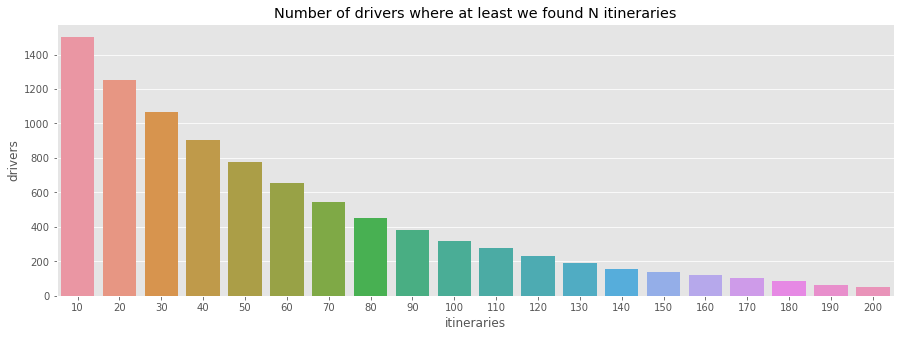

In [68]:
plt.figure(figsize=(15, 5))
y = [sum(df.itineraries > p) for p in [(i+1)*10 for i in range(20)]]
x = [p for p in [(i+1)*10 for i in range(20)]]
sns.barplot(x, y);
plt.title('Number of drivers where at least we found N itineraries');
plt.xlabel('itineraries');
plt.ylabel('drivers');

### Next plot will require an observation in detail

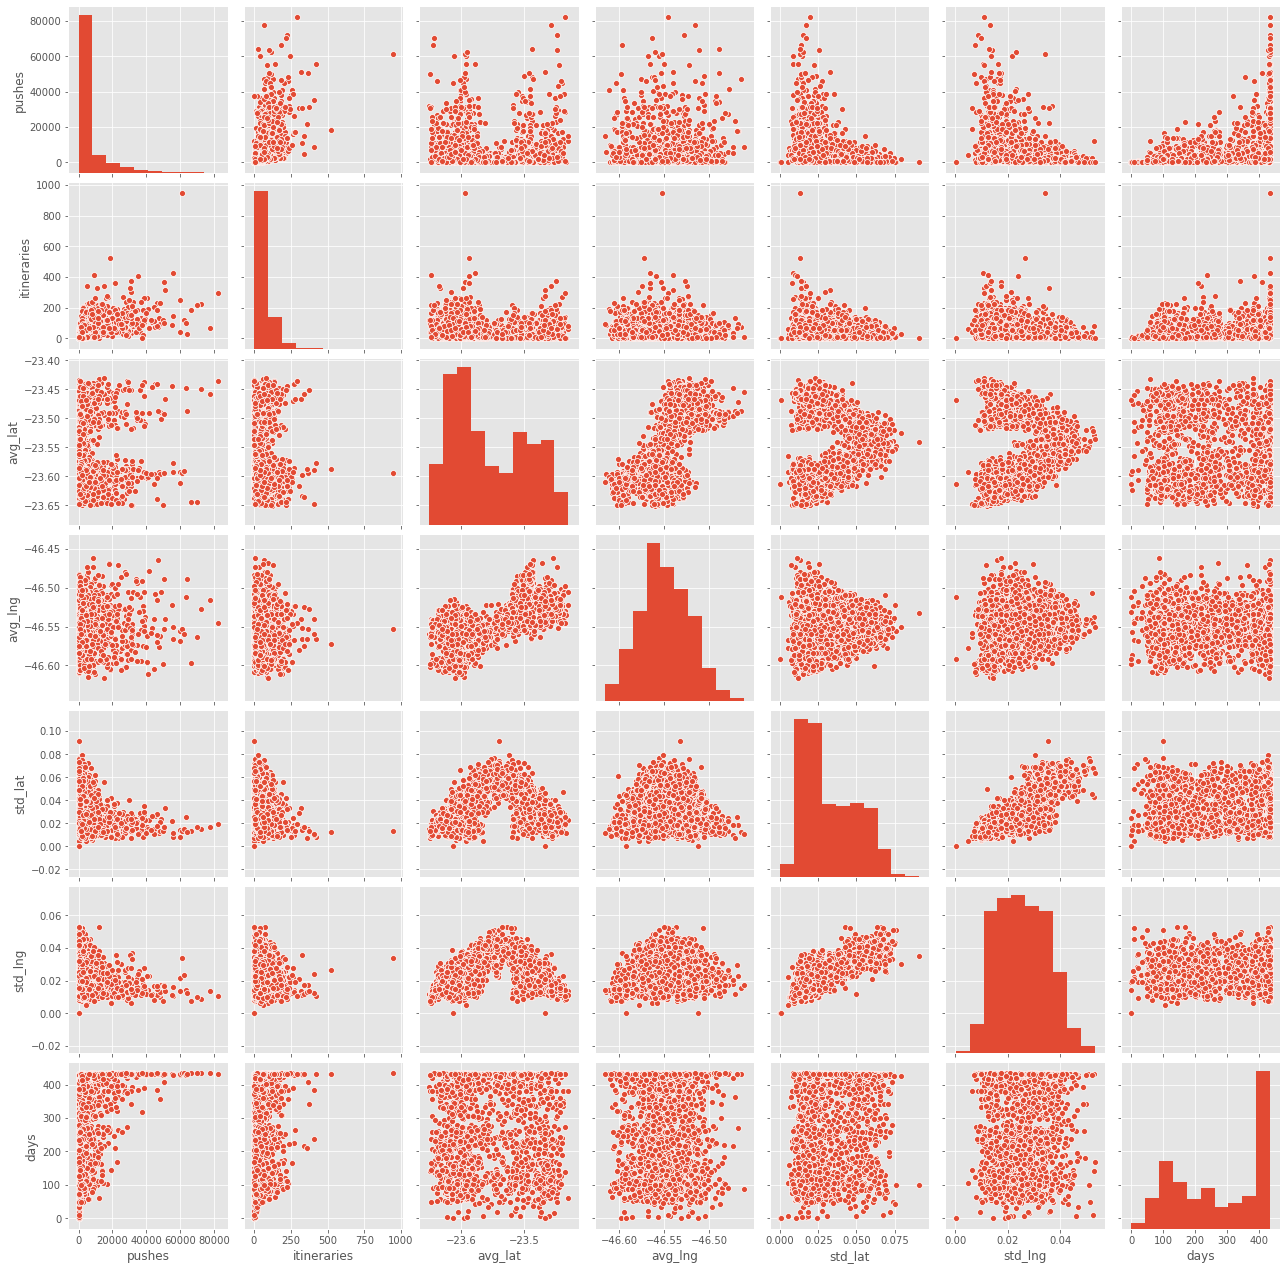

In [69]:
sns.pairplot(data=df);

- **days**: location are not correlated with days. And present little correlation against pushes and itineraries. Of course, the more you have worked, the more itineraries and messages will will achieve.
- **avg_lat**: against avg_lng shows an eight pseudo form. These average is taken from the whole dataset, so every part of the 'eight' belongs probabily to every agency zone of work. When we look the behaviour vs standard deviation of the latitude and longitude, something strange happens. We see like a house. The door/hole of the house could be the agency center latitud. It is unexpected that a driver presents and average latitude identical to the agency latitude with a standard deviation equals to zero. If your location is the agency, you need to move to transport the packages.
- **avg_lng**: there is no door/hole of the house. This could means that the agency moves tend to be vertical and not horizontals.
- If we have reason about the door/hole as a possible location of the agency, then the horizontal extremes of the house are locations far away from the agency. And at the same time, these extremes present lower standard deviation, so it could be possible that extremes represent drivers that are far ways from the agencies and that make delliveries near them.
- Another possible interpretation could be that the extremes represent the two agencies locations, and the center are the people in the middle, that have to do longer trips, and because of that, the bigger deviation. And the hole in latitude means that the agencies present an important vertical geographical gap.
- **std_lat**: shows a correlation vs std_lng. This has sense. If the driver is going to present geographical variance, it has to be in both direction, vertical and horizontal.
- **pushes**: show two towers vs avg_lat. The drivers tend to be near the agencies when using the Loggi's app. Then the every push location has to be near an agency. We do not see the two towers vs avg_lng. Then it is probable that the agencies where at different latitudes but similar longitudes. The more the pushes, the less the deviation. This could means that the drivers that send more pushes use to be near the agencies.
- **itineraries**: vs pushes we can detect some extremes cases where the more the pushes the more the itineraries. But the normal isn't that. Is like that the number of pushes is not related with the number of itineraries. if we are right at the agencies latitude locations, then the itineraries vs avg_lat could means that one agency has a few more itineraries than the other. And maybe the closer the avg_lat and avg_lng a driver is from an agency, the more the number of itineraries he has. Looking at the deviation, the more you move, the less itineraries you do (with some extremes exceptions)


### Let see the correlations between the variables

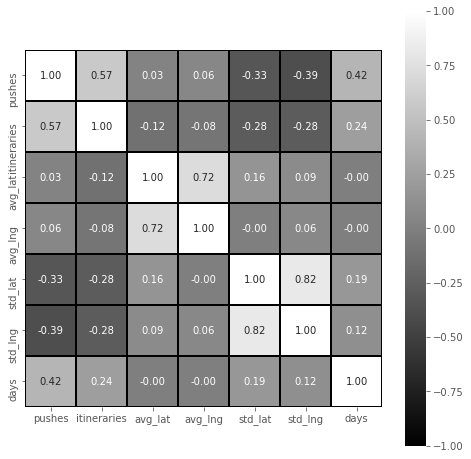

In [70]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

- The number of itineraries is correlated with the number of pushes

### Let's try to plot the avg driver locations

In [13]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "markers",
    lon = df['avg_lng'].values[:],
    lat = df['avg_lat'].values[:],
    marker = {'size': 5, 'color': 'rgba(255, 100, 100, 0.5)'}))
    
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

### Identify driver by location variance

In [51]:
# we add the latitude and longitude variations
p = df['std_lat'] + df['std_lng']
p = p.apply(lambda x: (x - p.mean()) / p.std())
p = p.abs()
p[p.isna()] = 0
p = p.astype('int')
p.unique()

array([0, 1, 2])

In [56]:
colors = ['rgba(200, 255, 200, 0.7)',
          'rgba(255, 200, 200, 0.7)',
          'rgba(200, 200, 255, 0.7)']

fig = go.Figure()

for s in p.unique():
    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        name = '< {} std'.format(s+1),
        lon = df[p == s]['avg_lng'].values[:],
        lat = df[p == s]['avg_lat'].values[:],
        marker = {'size': 5 + s*10, 'color': colors[s]}))
    
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()

### Identidy driver by number of itineraries

In [57]:
p = df['itineraries']
groups = [200, 100, 60, 30, 20, 10, 0]
def classify(x):
    for i, s in enumerate(groups):
        if x >= s: return len(groups)-i-1
    assert(1 == 2)
    
p = p.apply(classify)

In [58]:
mc = {0: 'rgba(000, 255, 255, 0.6)',
      1: 'rgba(000, 255, 255, 0.9)',
      2: 'rgba(255, 200, 200, 0.2)',
      3: 'rgba(255, 150, 150, 0.3)',
      4: 'rgba(255, 150, 150, 0.5)',
      5: 'rgba(255, 150, 150, 0.7)',
      6: 'rgba(255, 100, 100, 0.9)'}
#
fig = go.Figure()

groups.sort()

cls = p.unique()
cls.sort()
for c in cls:
    if c != len(groups)-1:
        name = str(groups[c]) + ' - ' + str(groups[c+1])
    else:
        name = '> ' + str(groups[c])
        
    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        name = name,
        lon = df[p == c]['avg_lng'].values[:],
        lat = df[p == c]['avg_lat'].values[:],
        marker = {'size': 5 + c*2, 'color': mc[c]}))
    
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['avg_lng'].mean(), 'lat': df['avg_lat'].mean()},
        'style': "carto-positron",
        'zoom': 10})

fig.show()